# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install Pillow


In [ ]:

!pip install scipy==1.1.0



In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final /part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

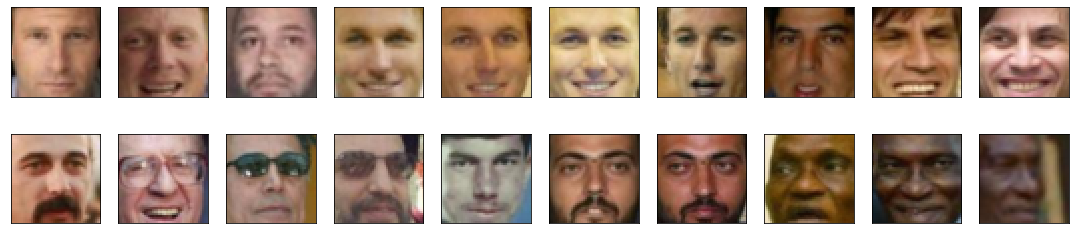

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W, n_row=2, n_col=10)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
def convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  
  image = image.clip(0, 1)
  
  return image

In [ ]:
from torchvision import transforms, models

In [ ]:
x_train = []
x_val = []


In [ ]:
for i in range(TRAIN_SIZE):
  x_train.append(transforms.ToTensor()(X_train[i]))

for i in range(VAL_SIZE):
  x_val.append(transforms.ToTensor()(X_val[i]))
    

In [ ]:
image = convert(x_train[0])

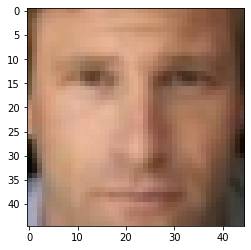

In [ ]:
plt.imshow(X_train[0])

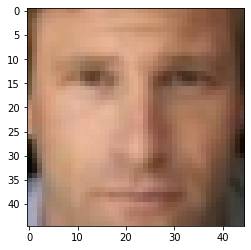

In [ ]:
plt.imshow(image)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)
data_val = DataLoader(x_val, batch_size=batch_size, shuffle=True)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

In [ ]:
inp_size

45

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

Линейный декодер:

In [ ]:
from copy import deepcopy
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_linear_1 = nn.Linear(11 * 11 * 20, 200)
      self.enc_linear_2 = nn.Linear(200, dim_code)
      


      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 45 * 45 * 3)
      #  <определите архитектуры encoder и decoder>
        
    def forward(self, x):
      latent_code = self.encode(x)
      reconstruction = self.decode(latent_code)

      #  <реализуйте forward проход автоэнкодера
      #  в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
      #  и полученная реконструкция изображения (reconstruction)>
        
      return reconstruction, latent_code
    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22
      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = code.view([-1, 11 * 11 * 20])
      code = F.relu(self.enc_linear_1(code))
      code = F.sigmoid(self.enc_linear_2(code))
      return code

    def decode(self, code):
      out = F.relu(self.dec_linear_1(code))
      out = F.sigmoid(self.dec_linear_2(out))
      out = out.view([-1, 3, 45, 45])
      return out

С использованием сверточных слоев в декодере:

In [ ]:
from copy import deepcopy
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_cnn_3 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=3, padding=1) # 50 * 10 * 10
      
      self.enc_linear_1 = nn.Linear(50 * 5 * 5, 11 * 11 * 20)
      self.enc_linear_2 = nn.Linear(11 * 11 * 20, 200)
      self.enc_linear_3 = nn.Linear(200, dim_code)
      
      
      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 50 * 5 * 5)
      
      self.dec_cnn_1 = nn.ConvTranspose2d(in_channels = 50 , out_channels = 20, kernel_size = 3, stride = 2) #20 * 11 * 11
      self.dec_cnn_2 = nn.ConvTranspose2d(in_channels = 20 , out_channels = 10, kernel_size = 2, stride = 2) #10 * 22 * 22
      self.dec_cnn_3 = nn.ConvTranspose2d(in_channels = 10 , out_channels = 3, kernel_size = 3, stride = 2) #3 * 45 * 45
      
    
      #  <определите архитектуры encoder и decoder>

    def forward(self, x):
      latent_code = self.encode(x)
      reconstruction = self.decode(latent_code)

      #  <реализуйте forward проход автоэнкодера
      #  в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
      #  и полученная реконструкция изображения (reconstruction)>
        
      return reconstruction, latent_code
    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22

      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = self.enc_cnn_3(code)  # 50,10,10
      code = F.relu(F.max_pool2d(code, 2)) # 50,5,5


      code = code.view([-1, 50 * 5 * 5])
      code = code.view([-1, 50 * 5 * 5])
      code = F.relu(self.enc_linear_1(code))
      code = F.relu(self.enc_linear_2(code))
      code = (self.enc_linear_3(code))
      return code

    def decode(self, code):
      
      out = F.relu(self.dec_linear_1(code)) # 11 * 11 * 20
      out = F.relu(self.dec_linear_2(out))

      out = out.view([-1, 50, 5, 5]) 

      
      out = F.relu(self.dec_cnn_1(out))
      out = F.relu(self.dec_cnn_2(out))  #10 * 22 * 22


      out = F.sigmoid(self.dec_cnn_3(out))
      return out

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.014497,	val Loss: 0.010452 
Epoch: 2 	Training Loss: 0.009572,	val Loss: 0.008746 
Epoch: 3 	Training Loss: 0.008122,	val Loss: 0.007677 
Epoch: 4 	Training Loss: 0.007024,	val Loss: 0.006769 
Epoch: 5 	Training Loss: 0.006522,	val Loss: 0.006325 
Epoch: 6 	Training Loss: 0.006124,	val Loss: 0.006102 
Epoch: 7 	Training Loss: 0.005781,	val Loss: 0.005803 
Epoch: 8 	Training Loss: 0.005490,	val Loss: 0.005575 
Epoch: 9 	Training Loss: 0.005242,	val Loss: 0.005407 
Epoch: 10 	Training Loss: 0.005002,	val Loss: 0.005179 
Epoch: 11 	Training Loss: 0.004794,	val Loss: 0.005119 
Epoch: 12 	Training Loss: 0.004641,	val Loss: 0.005035 
Epoch: 13 	Training Loss: 0.004514,	val Loss: 0.004929 
Epoch: 14 	Training Loss: 0.004390,	val Loss: 0.004889 
Epoch: 15 	Training Loss: 0.004280,	val Loss: 0.004796 
Epoch: 16 	Training Loss: 0.004190,	val Loss: 0.004728 
Epoch: 17 	Training Loss: 0.004107,	val Loss: 0.004752 
Epoch: 18 	Training Loss: 0.004020,	val Loss: 0.004562 
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 21 	Training Loss: 0.003792,	val Loss: 0.004451 
Epoch: 22 	Training Loss: 0.003720,	val Loss: 0.004453 
Epoch: 23 	Training Loss: 0.003657,	val Loss: 0.004416 
Epoch: 24 	Training Loss: 0.003604,	val Loss: 0.004405 
Epoch: 25 	Training Loss: 0.003563,	val Loss: 0.004408 
Epoch: 26 	Training Loss: 0.003513,	val Loss: 0.004419 
Epoch: 27 	Training Loss: 0.003483,	val Loss: 0.004390 
Epoch: 28 	Training Loss: 0.003442,	val Loss: 0.004324 
Epoch: 29 	Training Loss: 0.003410,	val Loss: 0.004331 
Epoch: 30 	Training Loss: 0.003376,	val Loss: 0.004368 
Epoch: 31 	Training Loss: 0.003343,	val Loss: 0.004317 
Epoch: 32 	Training Loss: 0.003307,	val Loss: 0.004346 
Epoch: 33 	Training Loss: 0.003281,	val Loss: 0.004366 
Epoch: 34 	Training Loss: 0.003251,	val Loss: 0.004261 
Epoch: 35 	Training Loss: 0.003235,	val Loss: 0.004234 
Epoch: 36 	Training Loss: 0.003188,	val Loss: 0.004265 
Epoch: 37 	Training Loss: 0.003178,	val Loss: 0.004206 
Epoch: 38 	Training Loss: 0.003144,	val Loss: 0.

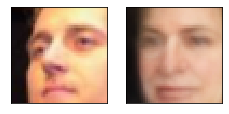

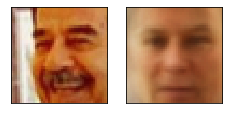

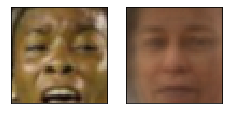

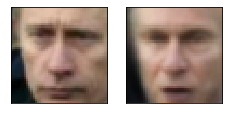

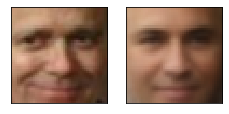

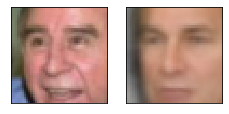

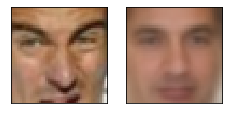

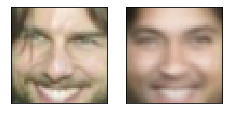

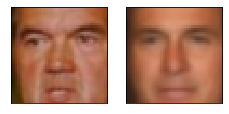

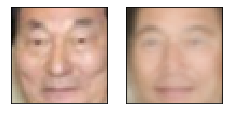

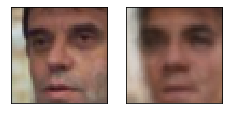

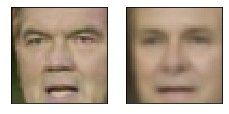

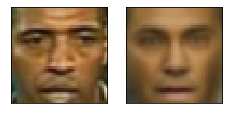

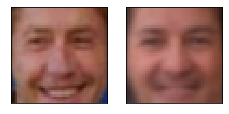

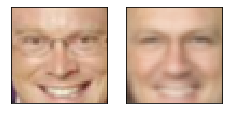

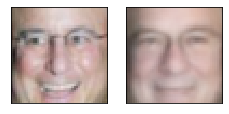

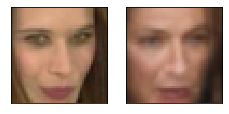

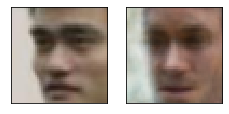

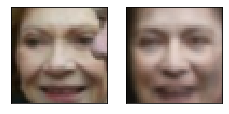

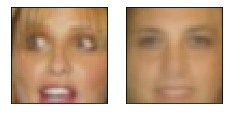

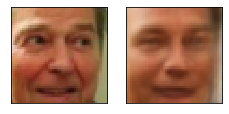

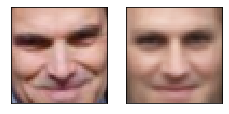

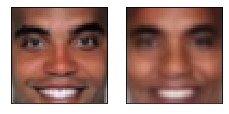

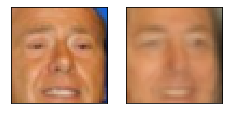

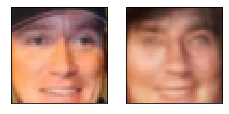

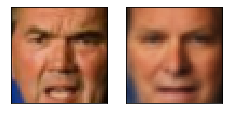

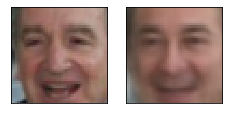

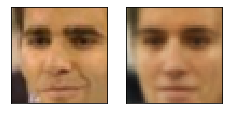

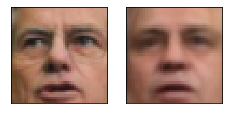

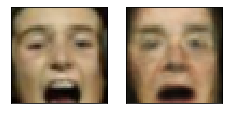

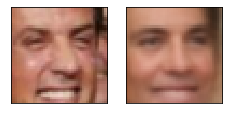

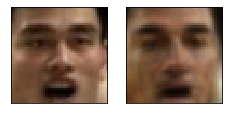

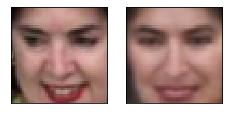

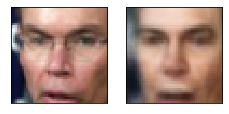

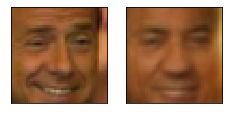

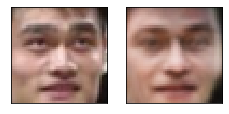

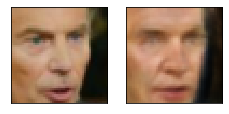

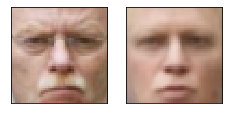

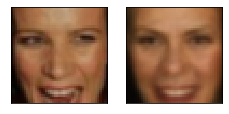

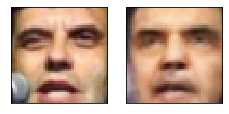

In [ ]:
n_epochs = 40
history_train = []
history_val = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images in data_tr:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        # calculate the loss
        loss = criterion(reconstruction, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 

    train_loss = train_loss/len(data_tr)
    history_train.append(train_loss)
    
    for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        # calculate the loss
        loss = criterion(reconstruction, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val.append(val_loss)
    
    plot_gallery([images[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        ))


Графики лоссов:

In [ ]:
epochs = np.linspace(1,30,30)

In [ ]:
epochs

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30.])

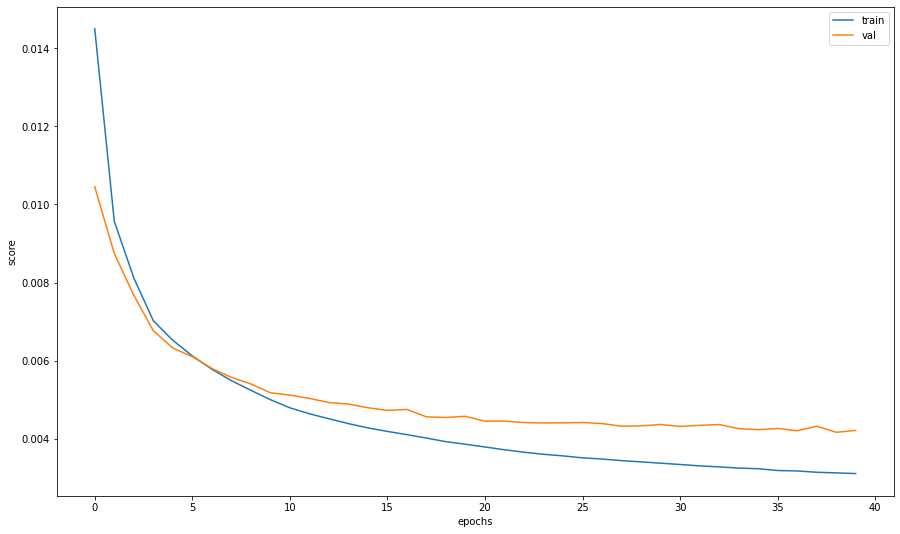

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(history_train, label="train")
plt.plot(history_val, label="val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

In [ ]:
b = images.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

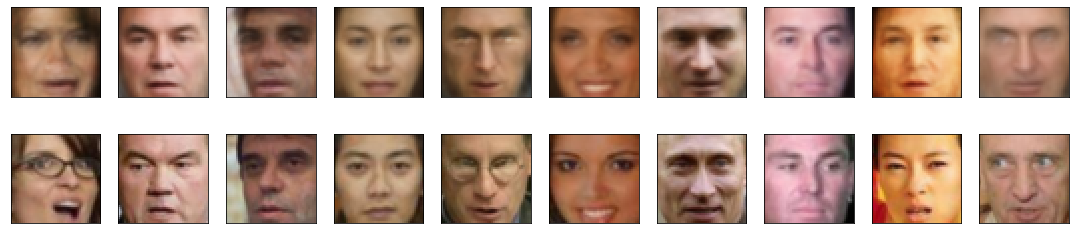

In [ ]:
plot_gallery(np.concatenate((a,b), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        


Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


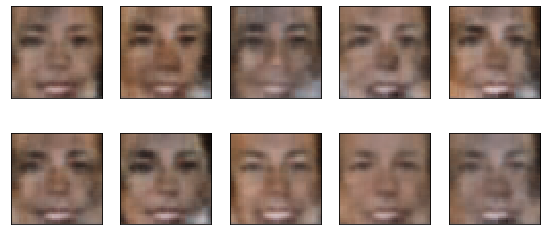

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.rand(10,100).to(device)
output = autoencoder.decode(z)
plot_gallery(output.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Найдем картинки с улыюками:

In [ ]:
SAD = [X_train[151], X_train[2], X_train[12], X_train[16], X_train[17], X_train[22], X_train[25], X_train[91], X_train[92], X_train[79], X_train[69], X_train[55], X_train[56], X_train[100], X_train[45], X_train[152] ]

In [ ]:
SMILE =[ X_train[1], X_train[3], X_train[4], X_train[5], X_train[8], X_train[9], X_train[11], X_train[18], X_train[26], X_train[34], X_train[58], X_train[60], X_train[83], X_train[98], X_train[106], X_train[88]  ]

Улыбающиесь и неулыбающиеся люди:

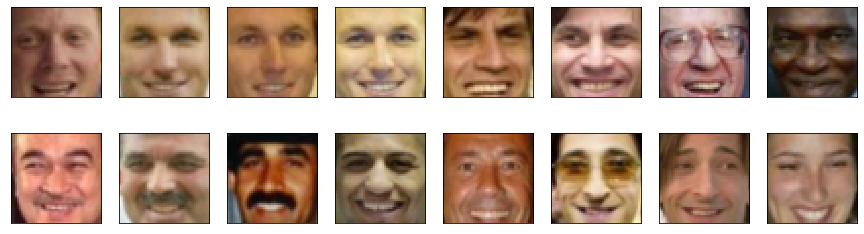

In [ ]:
plot_gallery(SMILE, IMAGE_H, IMAGE_W, n_row=2, n_col=8)

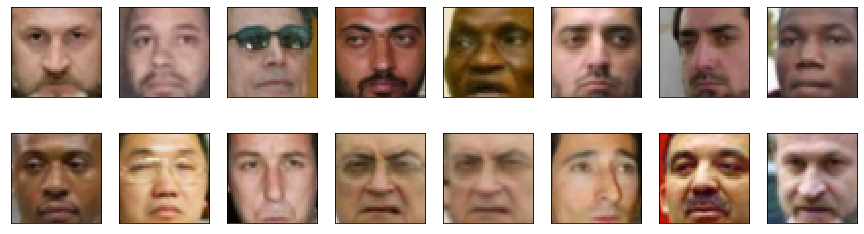

In [ ]:
plot_gallery(SAD, IMAGE_H, IMAGE_W, n_row=2, n_col=8)

In [ ]:
SMILE_TENSOR  = torch.Tensor(16,3,45,45)
SAD_TENSOR = torch.Tensor(16,3,45,45)
for i in range (16):
  SMILE_TENSOR[i] = transforms.ToTensor()(SMILE[i]) 
  SAD_TENSOR[i] = transforms.ToTensor()(SAD[i])

In [ ]:
SMILE_TENSOR = SMILE_TENSOR.to(device)
SAD_TENSOR = SAD_TENSOR.to(device)

In [ ]:
SMILE_VECTOR = autoencoder.encode(SMILE_TENSOR)
SAD_VECTOR = autoencoder.encode(SAD_TENSOR)

In [ ]:
VECTOR =  SMILE_VECTOR.mean(axis=0) - SAD_VECTOR.mean(axis=0)

In [ ]:
reconstruction, latent_code = autoencoder(images)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
latent_code = latent_code + VECTOR

In [ ]:
latent_code = latent_code.to(device)

In [ ]:
images_smile = autoencoder.decode(latent_code)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
d = images_smile.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

До:

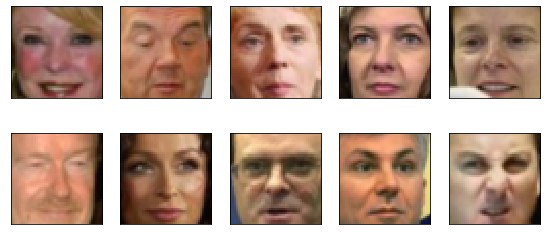

In [ ]:
plot_gallery(b, IMAGE_H, IMAGE_W, n_row=2, n_col=5)        


После:

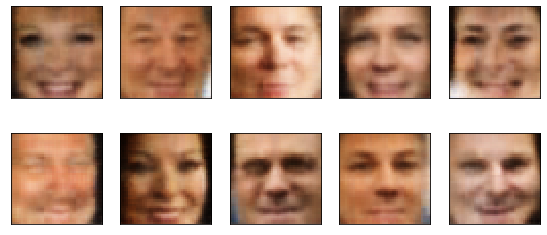

In [ ]:
plot_gallery(d, IMAGE_H, IMAGE_W, n_row=2, n_col=5)        


Сравнение:

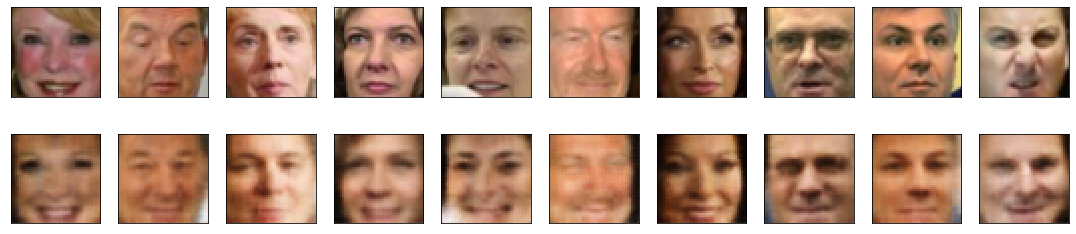

In [ ]:
plot_gallery(np.concatenate((b,d), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        


Из результатов видно, что у людей появдяются улыбки.

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self):
      super().__init__()
      
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_linear_1 = nn.Linear(11 * 11 * 20, 200)

      #для мат ожид
      self.enc_linear_2_mu = nn.Linear(200, dim_code)

      #для дисперсии
      self.enc_linear_2_logsigma = nn.Linear(200, dim_code)
     


      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 45 * 45 * 3)
      #  <определите архитектуры encoder и decoder>
      #  <определите архитектуры encoder и decoder
      #  помните, у encoder должны быть два "хвоста", 
      #  т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>



    def encode(self, x):
      # <реализуйте forward проход энкодера
      #  в качестве ваозвращаемых переменных -- mu и logsigma>

      code = self.enc_cnn_1(x) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22
      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = code.view([-1, 11 * 11 * 20])
      code = F.relu(self.enc_linear_1(code))

      mu = (self.enc_linear_2_mu(code))
      logsigma =(self.enc_linear_2_logsigma(code))
        
      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    def decode(self, code):
      #<реализуйте forward проход декодера
      #в качестве ваозвращаемой переменной -- reconstruction>  
      reconstruction = F.relu(self.dec_linear_1(code))
      reconstruction = F.sigmoid(self.dec_linear_2(reconstruction))
      reconstruction = reconstruction.view([-1, 3, 45, 45])
      return reconstruction
  

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
      mu, logsigma = self.encode(x)
      reconstruction = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decode(reconstruction)


      return mu, logsigma, reconstruction

С использованием сверточных слоев в декодере и увеличением количества слоев:

In [ ]:
from copy import deepcopy
class VAE(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_cnn_3 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=3, padding=1) # 50 * 10 * 10
      
      self.enc_linear_1 = nn.Linear(50 * 5 * 5, 11 * 11 * 20)
      self.enc_linear_2 = nn.Linear(11 * 11 * 20, 200)
      
      self.enc_linear_3_mu = nn.Linear(200, dim_code)
      self.enc_linear_3_logsigma = nn.Linear(200, dim_code)
      
      
      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 50 * 5 * 5)
      
      self.dec_cnn_1 = nn.ConvTranspose2d(in_channels = 50 , out_channels = 20, kernel_size = 3, stride = 2) #20 * 11 * 11
      self.dec_cnn_2 = nn.ConvTranspose2d(in_channels = 20 , out_channels = 10, kernel_size = 2, stride = 2) #10 * 22 * 22
      self.dec_cnn_3 = nn.ConvTranspose2d(in_channels = 10 , out_channels = 3, kernel_size = 3, stride = 2) #3 * 45 * 45
      
    
      #  <определите архитектуры encoder и decoder>


    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22

      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = self.enc_cnn_3(code)  # 50,10,10
      code = F.relu(F.max_pool2d(code, 2)) # 50,5,5


      code = code.view([-1, 50 * 5 * 5])
      code = code.view([-1, 50 * 5 * 5])
      code = F.relu(self.enc_linear_1(code))
      code = F.relu(self.enc_linear_2(code))


      mu = self.enc_linear_3_mu(code)
      logsigma = self.enc_linear_3_logsigma(code) 

      return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, code):
      
      out = F.relu(self.dec_linear_1(code)) # 11 * 11 * 20
      out = F.relu(self.dec_linear_2(out))

      out = out.view([-1, 50, 5, 5]) 

      
      out = F.relu(self.dec_cnn_1(out))
      out = F.relu(self.dec_cnn_2(out))  #10 * 22 * 22

      out = F.sigmoid(self.dec_cnn_3(out))
      
      return out

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
      mu, logsigma = self.encode(x)
      reconstruction = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decode(reconstruction)


      return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    loss /= 10 * 45 * 45
    #loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

VAE_autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(VAE_autoencoder.parameters(), lr=0.001)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.620700,	val Loss: 0.611692 
Epoch: 2 	Training Loss: 0.610761,	val Loss: 0.607665 
Epoch: 3 	Training Loss: 0.608227,	val Loss: 0.606397 
Epoch: 4 	Training Loss: 0.606822,	val Loss: 0.605262 
Epoch: 5 	Training Loss: 0.605964,	val Loss: 0.604818 
Epoch: 6 	Training Loss: 0.605357,	val Loss: 0.604927 
Epoch: 7 	Training Loss: 0.604868,	val Loss: 0.604340 
Epoch: 8 	Training Loss: 0.604371,	val Loss: 0.604056 
Epoch: 9 	Training Loss: 0.603973,	val Loss: 0.603478 
Epoch: 10 	Training Loss: 0.603659,	val Loss: 0.603473 
Epoch: 11 	Training Loss: 0.603414,	val Loss: 0.603368 
Epoch: 12 	Training Loss: 0.603153,	val Loss: 0.603190 
Epoch: 13 	Training Loss: 0.602935,	val Loss: 0.603095 
Epoch: 14 	Training Loss: 0.602721,	val Loss: 0.602877 
Epoch: 15 	Training Loss: 0.602625,	val Loss: 0.603009 
Epoch: 16 	Training Loss: 0.602430,	val Loss: 0.602923 
Epoch: 17 	Training Loss: 0.602370,	val Loss: 0.602703 
Epoch: 18 	Training Loss: 0.602190,	val Loss: 0.602887 
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 21 	Training Loss: 0.601888,	val Loss: 0.602715 
Epoch: 22 	Training Loss: 0.601749,	val Loss: 0.602850 
Epoch: 23 	Training Loss: 0.601647,	val Loss: 0.602750 
Epoch: 24 	Training Loss: 0.601621,	val Loss: 0.602733 
Epoch: 25 	Training Loss: 0.601534,	val Loss: 0.602715 
Epoch: 26 	Training Loss: 0.601422,	val Loss: 0.602636 
Epoch: 27 	Training Loss: 0.601354,	val Loss: 0.602625 
Epoch: 28 	Training Loss: 0.601320,	val Loss: 0.602714 
Epoch: 29 	Training Loss: 0.601229,	val Loss: 0.602542 
Epoch: 30 	Training Loss: 0.601191,	val Loss: 0.602815 
Epoch: 31 	Training Loss: 0.601112,	val Loss: 0.602937 
Epoch: 32 	Training Loss: 0.601064,	val Loss: 0.603114 
Epoch: 33 	Training Loss: 0.601037,	val Loss: 0.602715 
Epoch: 34 	Training Loss: 0.600993,	val Loss: 0.602672 
Epoch: 35 	Training Loss: 0.600943,	val Loss: 0.602814 
Epoch: 36 	Training Loss: 0.600942,	val Loss: 0.602740 
Epoch: 37 	Training Loss: 0.600810,	val Loss: 0.602719 
Epoch: 38 	Training Loss: 0.600827,	val Loss: 0.

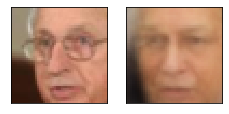

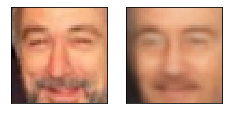

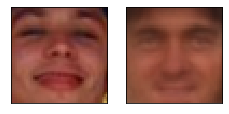

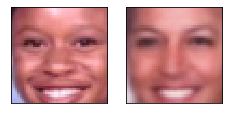

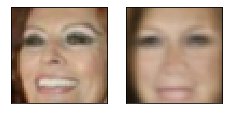

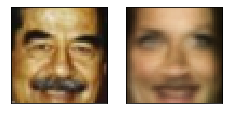

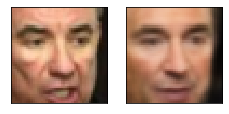

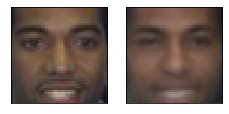

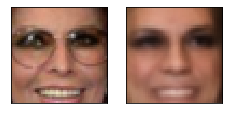

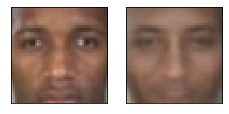

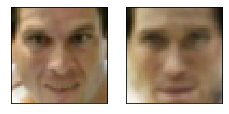

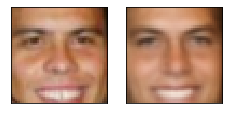

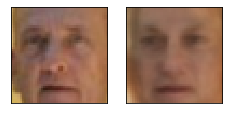

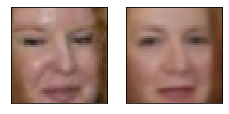

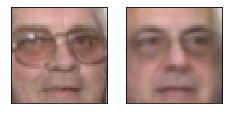

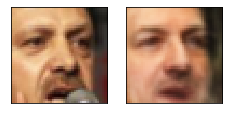

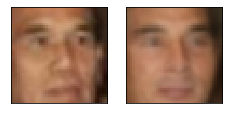

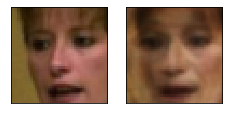

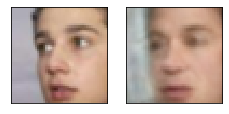

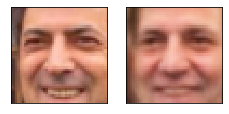

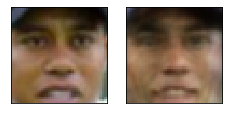

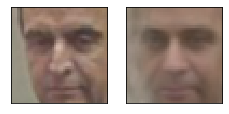

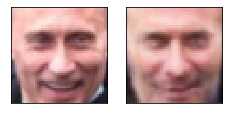

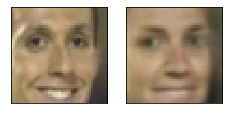

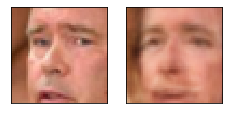

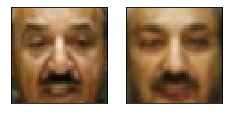

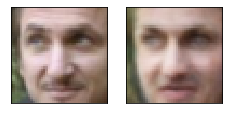

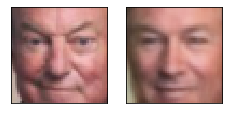

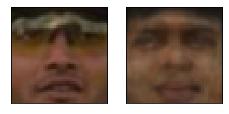

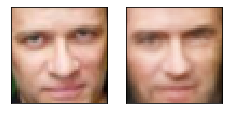

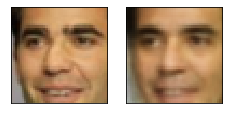

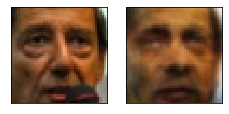

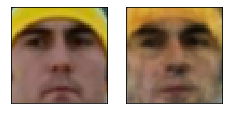

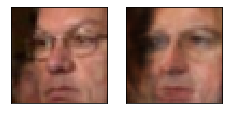

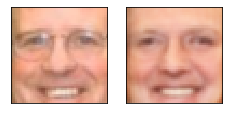

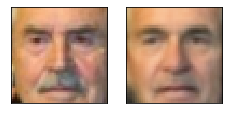

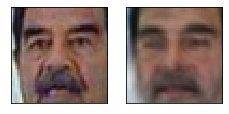

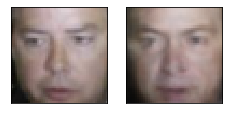

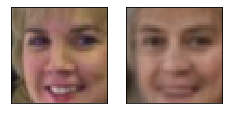

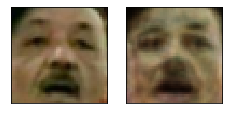

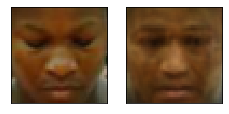

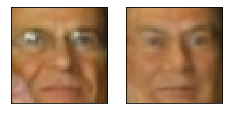

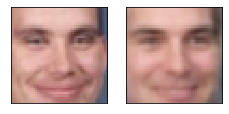

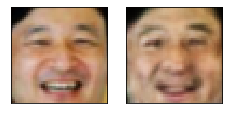

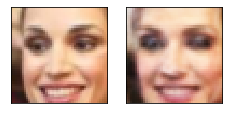

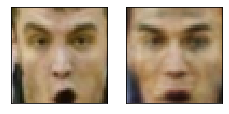

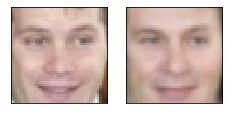

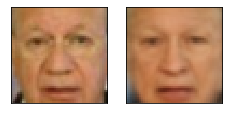

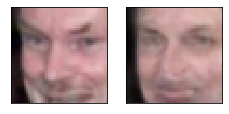

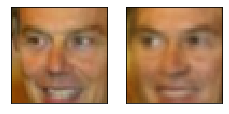

In [ ]:
n_epochs = 50
history_train_1 = []
history_val_1 = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images in data_tr:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)

        
        # calculate the loss
        loss = criterion(images, mu, logsigma, reconstruction)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 
    train_loss = train_loss/len(data_tr)
    history_train_1.append(train_loss)
    
    for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)
        # calculate the loss
        loss = criterion(images, mu, logsigma, reconstruction)
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val_1.append(val_loss)
    
    plot_gallery([images[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        )) 


Графики лоссов:

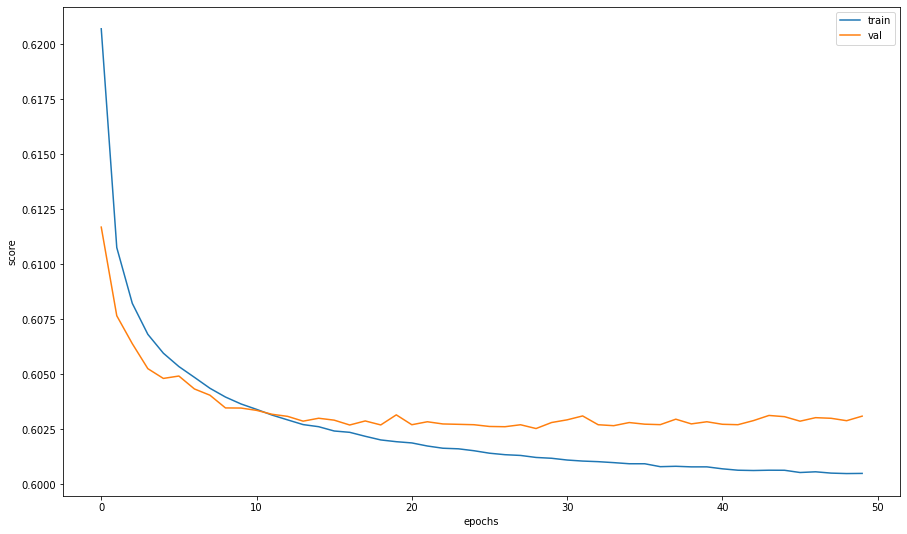

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(history_train_1, label="train")
plt.plot(history_val_1, label="val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)
        break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
b = images.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)


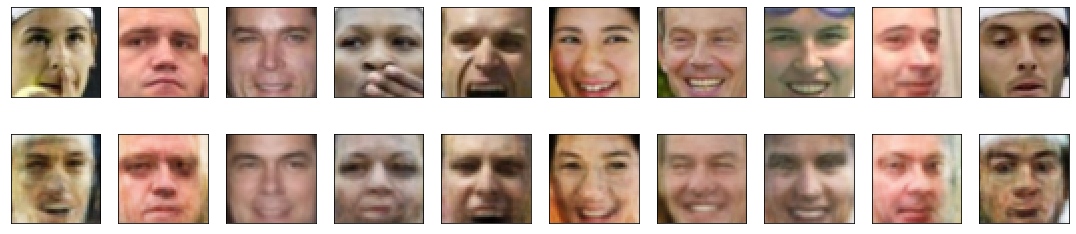

In [ ]:
plot_gallery(np.concatenate((b,a), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        


And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
torch_tensor = torch.from_numpy(z) 
torch_tensor = torch_tensor.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


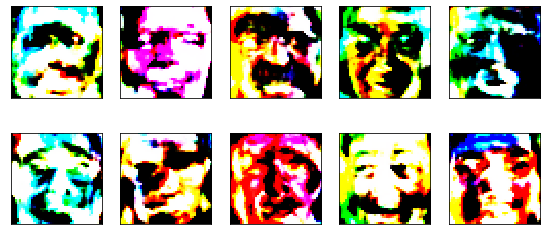

In [ ]:
output = VAE_autoencoder.decode(torch_tensor.float())
plot_gallery(output.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

Возьмем атрибут - Male

In [ ]:
f = open('lfw_attributes.txt')
data = []
colour = []

In [ ]:
for line in f:
  data.append(line.split('\t'))

In [ ]:
for i in range(2,2+TRAIN_SIZE):
  colour.append(float(data[i][2]))

In [ ]:
data_visualization = DataLoader(x_train, batch_size=batch_size, shuffle=False)


In [ ]:
LATENT_VECTORS=[]

In [ ]:
for images in data_visualization:
  images = images.to(device)
  mu, logsigma, reconstruction = VAE_autoencoder(images)
  Latent_vector = VAE_autoencoder.gaussian_sampler(mu, logsigma)
  LATENT_VECTORS.append(Latent_vector.data.cpu().numpy())


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
LATENT_VECTORS_ = []

In [ ]:
for vec in LATENT_VECTORS:
  for i in range(10):
    LATENT_VECTORS_.append(vec[i])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(LATENT_VECTORS_)

In [ ]:
len(colour)

10000

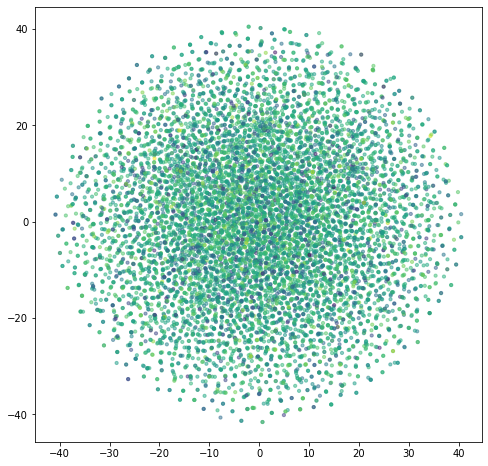

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,1], s=10, alpha=0.5, c = colour)
fig.set_figwidth(8)     #  ширина и
fig.set_figheight(8)

Что вы думаете о виде латентного представления?

Получили верные результаты.

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

Реализуем 1 вариант:

In [ ]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): 
       
        inputs = torch.cat([x, c], 1) 
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu

    def decode(self, z, c): 
     
        inputs = torch.cat([z, c], 1) 
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparametrize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [ ]:

def to_var(x):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return to_var(targets)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
use_cuda = True
batch_size = 32
latent_size = 20 

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(test_loader):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
model = CVAE(28*28, latent_size, 10)
if use_cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(1, 20):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.112336
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.007660
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.006855
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.007650
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007316
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.006225
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.007179
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.006754
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007599
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.006557
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.006817
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.006456
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.007230
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.007096
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.007724
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.007468
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.007052
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.006342
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.007211
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.006600
Train Epoch: 6 [0/60000 (

In [ ]:
LATENT_VECTORS_MNIST=[]
colours=[]

In [ ]:
for batch_idx, (data, labels) in enumerate(train_loader):
  break;

In [ ]:
data.shape

torch.Size([32, 1, 28, 28])

In [ ]:
labels

tensor([7, 8, 0, 1, 6, 9, 1, 9, 5, 3, 3, 2, 7, 5, 8, 6, 0, 2, 6, 4, 4, 5, 2, 0,
        3, 0, 5, 3, 3, 4, 6, 9])

In [ ]:
for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data)
        colours.append(labels.data.cpu().numpy())
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        z = model.reparametrize(mu, logvar)
        LATENT_VECTORS_MNIST.append(z.data.cpu().numpy())
   

In [ ]:
len(LATENT_VECTORS_MNIST)

1875

In [ ]:
LATENT_VECTORS_MNIST[1874].shape

(32, 20)

In [ ]:
COLOURS = []
LAT_VECTORS_MNIST=[]

In [ ]:
for vec in colours:
  for i in range(vec.shape[0]):
    COLOURS.append(vec[i])

for vec in LATENT_VECTORS_MNIST:
  for i in range(vec.shape[0]):
    LAT_VECTORS_MNIST.append(vec[i])



In [ ]:
COLOURS = COLOURS[:10000]
LAT_VECTORS_MNIST=LAT_VECTORS_MNIST[:10000]

In [ ]:
from sklearn.manifold import TSNE
def drow_latent(mass, colour):
  X_embedded = TSNE(n_components=2).fit_transform(mass)
  fig, ax = plt.subplots()
  ax.scatter(X_embedded[:,0], X_embedded[:,1], s=10, alpha=0.5,c = colour)
  fig.set_figwidth(8)     #  ширина и
  fig.set_figheight(8)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

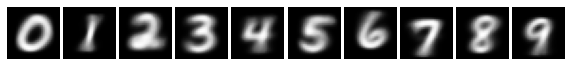

In [ ]:
import matplotlib.gridspec as gridspec

c = torch.eye(10, 10) # цифры от 0 до 9
c = to_var(c)
z = to_var(torch.randn(10, latent_size))
samples = model.decode(z, c).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

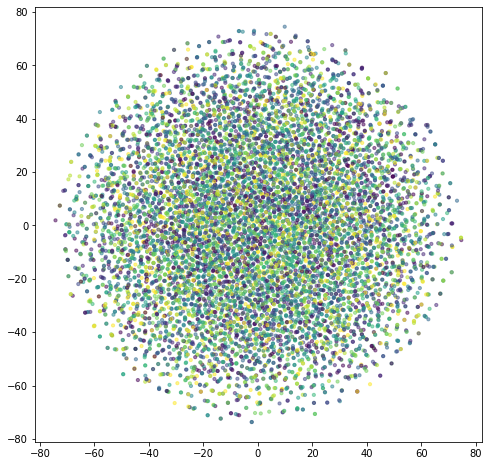

In [ ]:
drow_latent(LAT_VECTORS_MNIST, COLOURS)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Как мы видим тут также нормальное распределение. Качественно графики не сильно отличася.


# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
for img in data_tr:
  img = img.to(device)
  reconstruction, latent_code = autoencoder(img)
  break;
IMG_1 = img[0]
IMG_2 = img[3]
VEC_1 = latent_code[0]
VEC_2 = latent_code[3]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Конечное фото:

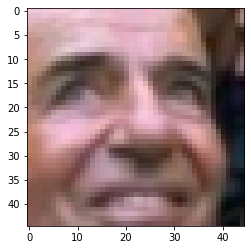

In [ ]:
plt.imshow(convert(IMG_1))

Начальное фото:

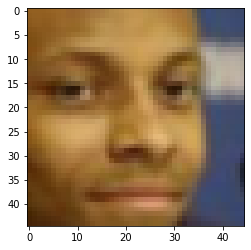

In [ ]:
plt.imshow(convert(IMG_2))

In [ ]:
vec1 = autoencoder.decode(VEC_1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
BONUS_1 = torch.Tensor(11,100)
for i in range(11):
  BONUS_1[i] = ((i * 0.1) * VEC_1 + (1 - i * 0.1) * VEC_2)

In [ ]:
BONUS_1=BONUS_1.to(device)

In [ ]:
vectors = autoencoder.decode(BONUS_1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
vectors.shape

torch.Size([11, 3, 45, 45])

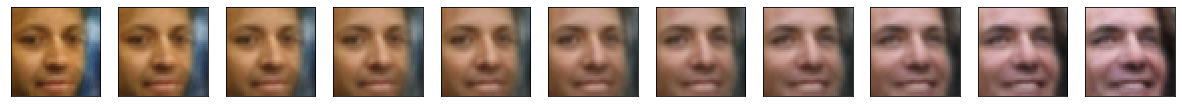

In [ ]:
a = vectors.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(a, IMAGE_H, IMAGE_W, n_row=1, n_col=11)    

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]

In [ ]:
def get_nois(img):
  noise_factor = 20
  X_noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape) 
  return X_noisy

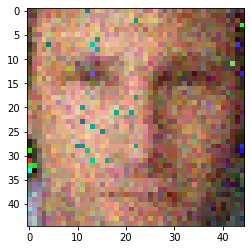

In [ ]:
plt.imshow(get_nois(X_train[0]).astype(np.uint8))

In [ ]:
NOISE_TRAIN = []
NOISE_VAL = []
for i in range(TRAIN_SIZE):
  NOISE_TRAIN.append((transforms.ToTensor()(X_train[i]), transforms.ToTensor()(get_nois(X_train[i]).astype(np.uint8))))

for i in range(VAL_SIZE):
  NOISE_VAL.append((transforms.ToTensor()(X_val[i]), transforms.ToTensor()(get_nois(X_val[i]).astype(np.uint8))))


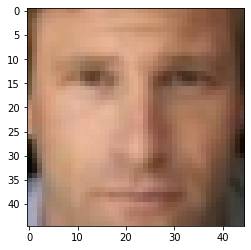

In [ ]:
plt.imshow(convert(NOISE_TRAIN[0][0]))

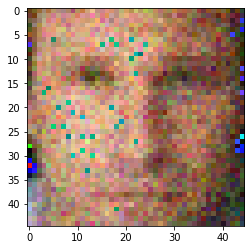

In [ ]:
plt.imshow(convert(NOISE_TRAIN[0][1]))

Подготовим данные:

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr_noise = DataLoader(NOISE_TRAIN, batch_size=batch_size, shuffle=True)
data_val_noise = DataLoader(NOISE_VAL, batch_size=batch_size, shuffle=True)

In [ ]:
for images in data_tr_noise:
  break;

In [ ]:
images[1].shape

torch.Size([10, 3, 45, 45])

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.030242,	val Loss: 0.026199 
Epoch: 2 	Training Loss: 0.024961,	val Loss: 0.024285 
Epoch: 3 	Training Loss: 0.024083,	val Loss: 0.024108 
Epoch: 4 	Training Loss: 0.023732,	val Loss: 0.023531 
Epoch: 5 	Training Loss: 0.023197,	val Loss: 0.023146 
Epoch: 6 	Training Loss: 0.022850,	val Loss: 0.023018 
Epoch: 7 	Training Loss: 0.022600,	val Loss: 0.022610 
Epoch: 8 	Training Loss: 0.022304,	val Loss: 0.022374 
Epoch: 9 	Training Loss: 0.021988,	val Loss: 0.022076 
Epoch: 10 	Training Loss: 0.021747,	val Loss: 0.021975 
Epoch: 11 	Training Loss: 0.021512,	val Loss: 0.021766 
Epoch: 12 	Training Loss: 0.021244,	val Loss: 0.021460 
Epoch: 13 	Training Loss: 0.021046,	val Loss: 0.021297 
Epoch: 14 	Training Loss: 0.020941,	val Loss: 0.021283 
Epoch: 15 	Training Loss: 0.020835,	val Loss: 0.021255 
Epoch: 16 	Training Loss: 0.020717,	val Loss: 0.021206 
Epoch: 17 	Training Loss: 0.020623,	val Loss: 0.021042 
Epoch: 18 	Training Loss: 0.020509,	val Loss: 0.021018 
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 21 	Training Loss: 0.020255,	val Loss: 0.020822 
Epoch: 22 	Training Loss: 0.020179,	val Loss: 0.020800 
Epoch: 23 	Training Loss: 0.020107,	val Loss: 0.020751 
Epoch: 24 	Training Loss: 0.020052,	val Loss: 0.020734 
Epoch: 25 	Training Loss: 0.019942,	val Loss: 0.020698 
Epoch: 26 	Training Loss: 0.019903,	val Loss: 0.020648 
Epoch: 27 	Training Loss: 0.019836,	val Loss: 0.020597 
Epoch: 28 	Training Loss: 0.019768,	val Loss: 0.020598 
Epoch: 29 	Training Loss: 0.019729,	val Loss: 0.020549 
Epoch: 30 	Training Loss: 0.019652,	val Loss: 0.020580 


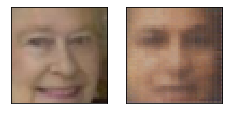

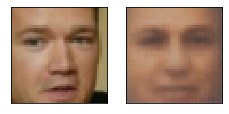

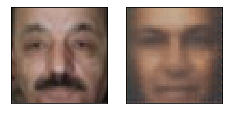

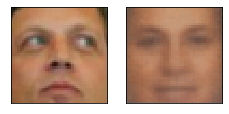

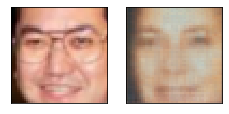

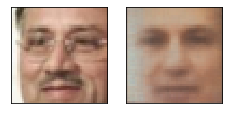

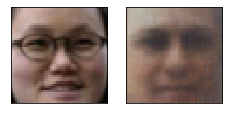

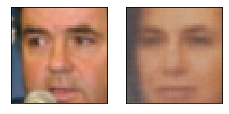

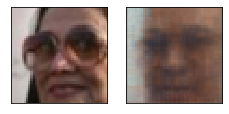

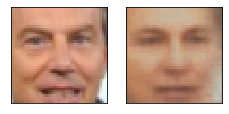

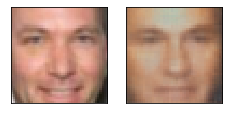

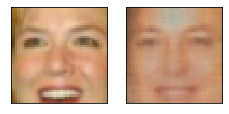

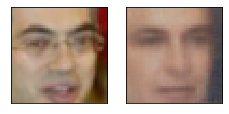

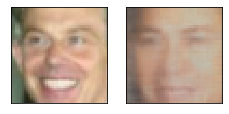

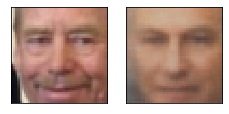

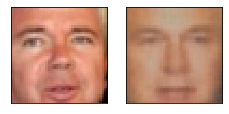

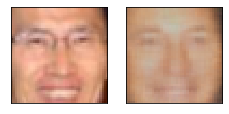

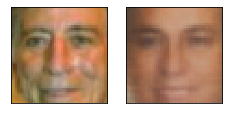

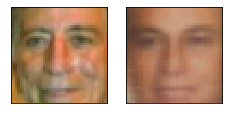

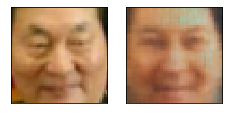

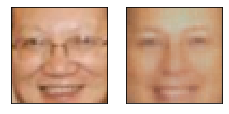

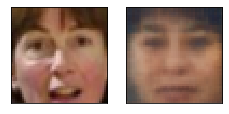

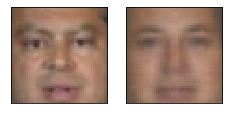

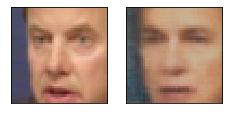

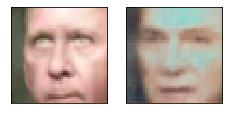

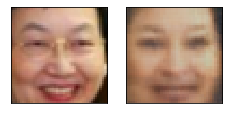

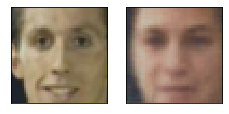

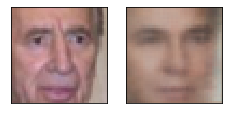

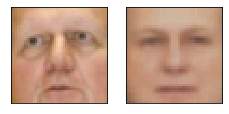

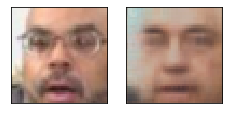

In [ ]:
n_epochs = 30
history_train_noise = []
history_val_noise = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images in data_tr_noise:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0])
        # calculate the loss
        loss = criterion(reconstruction, images[1])
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 

    train_loss = train_loss/len(data_tr_noise)
    history_train_noise.append(train_loss)
    
    for images in data_val_noise:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0])
        # calculate the loss
        loss = criterion(reconstruction, images[1])
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val_noise.append(val_loss)
    
    plot_gallery([images[0][0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        ))


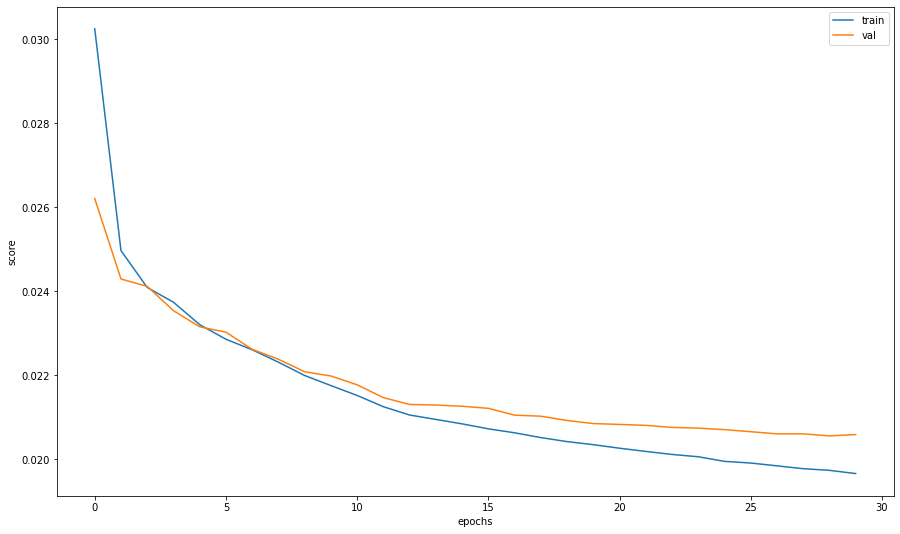

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(history_train_noise, label="train")
plt.plot(history_val_noise, label="val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
for images in data_val_noise:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0])
        break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

In [ ]:
b = images[1].to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

Сравним результаты до и после:

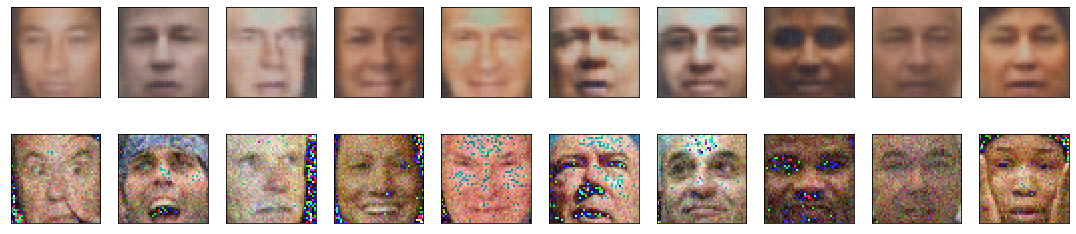

In [ ]:
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
b = images[1].to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(np.concatenate((a,b), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        


Как видно, шумы пропадают, модель работает верно. 

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

Определим функцию rand_img, которая будет генерировать пропуски в фотографии.

In [ ]:
from random import randint
randint(10, 20)

12

In [ ]:
def rand_img(img):
  img1 = img.copy()
  x = randint(0, 45-5)
  y = randint(0, 45-5)
  for i in range(x, x+5):
    for j in range(y, y+5):
      img1[i][j]=0
  return img1


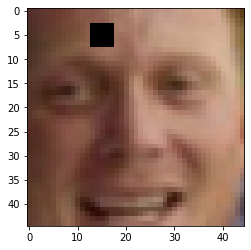

In [ ]:
plt.imshow(rand_img(X_train[1]))

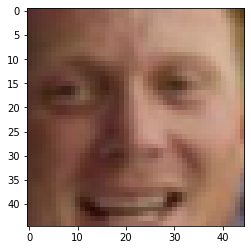

In [ ]:
plt.imshow((X_train[1]))

In [ ]:
SPACE_TRAIN = []
SPACE_VAL = []
for i in range(TRAIN_SIZE):
  SPACE_TRAIN.append((transforms.ToTensor()(X_train[i]), transforms.ToTensor()(rand_img(X_train[i]))))

for i in range(VAL_SIZE):
  SPACE_VAL.append((transforms.ToTensor()(X_val[i]), transforms.ToTensor()(rand_img(X_val[i]))))

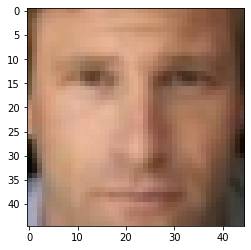

In [ ]:
plt.imshow(convert(SPACE_TRAIN[0][0]))

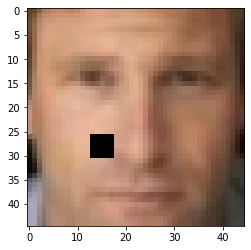

In [ ]:
plt.imshow(convert(SPACE_TRAIN[0][1]))

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr_space = DataLoader(SPACE_TRAIN, batch_size=batch_size, shuffle=True)
data_val_space = DataLoader(SPACE_VAL, batch_size=batch_size, shuffle=True)

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.022797,	val Loss: 0.017464 
Epoch: 2 	Training Loss: 0.016179,	val Loss: 0.015490 
Epoch: 3 	Training Loss: 0.015030,	val Loss: 0.014590 
Epoch: 4 	Training Loss: 0.014233,	val Loss: 0.013712 
Epoch: 5 	Training Loss: 0.013307,	val Loss: 0.013069 
Epoch: 6 	Training Loss: 0.013042,	val Loss: 0.012738 
Epoch: 7 	Training Loss: 0.012655,	val Loss: 0.012628 
Epoch: 8 	Training Loss: 0.012448,	val Loss: 0.012340 
Epoch: 9 	Training Loss: 0.012308,	val Loss: 0.012334 
Epoch: 10 	Training Loss: 0.012025,	val Loss: 0.012078 
Epoch: 11 	Training Loss: 0.011812,	val Loss: 0.011905 
Epoch: 12 	Training Loss: 0.011638,	val Loss: 0.011635 
Epoch: 13 	Training Loss: 0.011306,	val Loss: 0.011528 
Epoch: 14 	Training Loss: 0.011074,	val Loss: 0.011100 
Epoch: 15 	Training Loss: 0.010808,	val Loss: 0.010858 
Epoch: 16 	Training Loss: 0.010546,	val Loss: 0.010833 
Epoch: 17 	Training Loss: 0.010363,	val Loss: 0.010632 
Epoch: 18 	Training Loss: 0.010243,	val Loss: 0.010564 
E

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 21 	Training Loss: 0.009861,	val Loss: 0.010382 
Epoch: 22 	Training Loss: 0.009740,	val Loss: 0.010348 
Epoch: 23 	Training Loss: 0.009620,	val Loss: 0.010268 
Epoch: 24 	Training Loss: 0.009491,	val Loss: 0.010314 
Epoch: 25 	Training Loss: 0.009385,	val Loss: 0.010224 
Epoch: 26 	Training Loss: 0.009287,	val Loss: 0.010209 
Epoch: 27 	Training Loss: 0.009192,	val Loss: 0.010247 
Epoch: 28 	Training Loss: 0.009081,	val Loss: 0.010191 
Epoch: 29 	Training Loss: 0.008968,	val Loss: 0.010141 
Epoch: 30 	Training Loss: 0.008878,	val Loss: 0.010222 


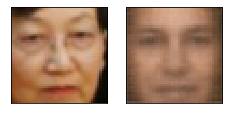

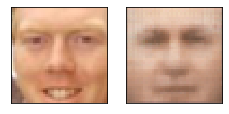

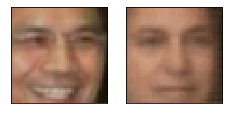

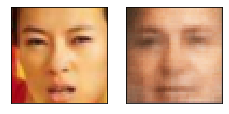

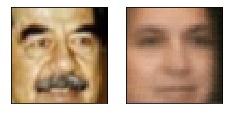

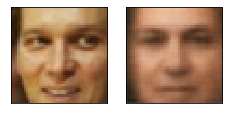

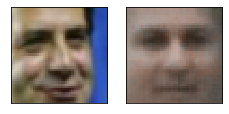

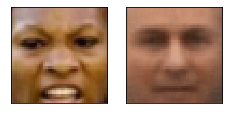

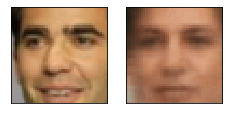

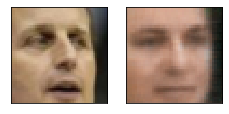

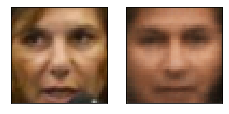

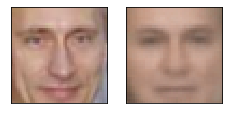

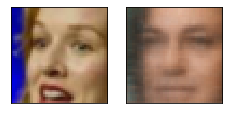

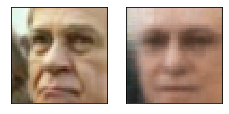

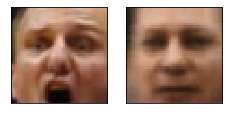

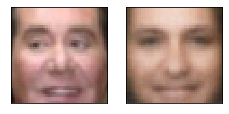

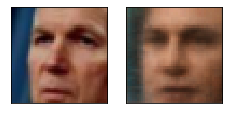

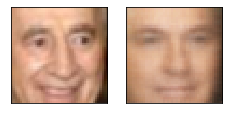

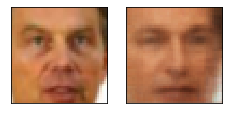

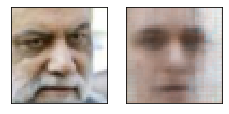

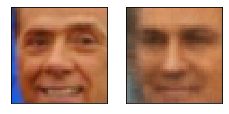

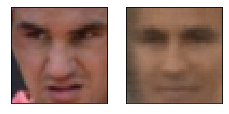

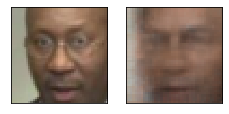

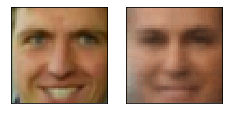

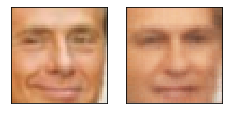

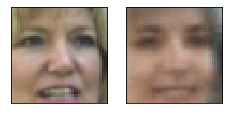

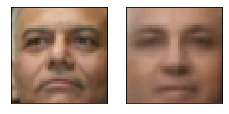

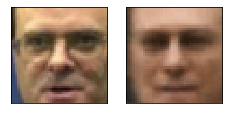

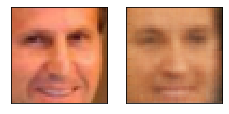

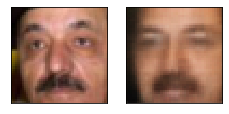

In [ ]:
n_epochs = 30
history_train_space = []
history_val_space = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    for images in data_tr_space:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0])
        # calculate the loss
        loss = criterion(reconstruction, images[1])
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.cpu().detach().numpy()
    #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        
    #print avg training statistics 

    train_loss = train_loss/len(data_tr_noise)
    history_train_space.append(train_loss)
    
    for images in data_val_space:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0])
        # calculate the loss
        loss = criterion(reconstruction, images[1])
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val_space.append(val_loss)
    
    plot_gallery([images[0][0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        ))


In [ ]:
for images in data_val_space:
        # _ stands in for labels, here
        # no need to flatten images
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images[0])
        break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


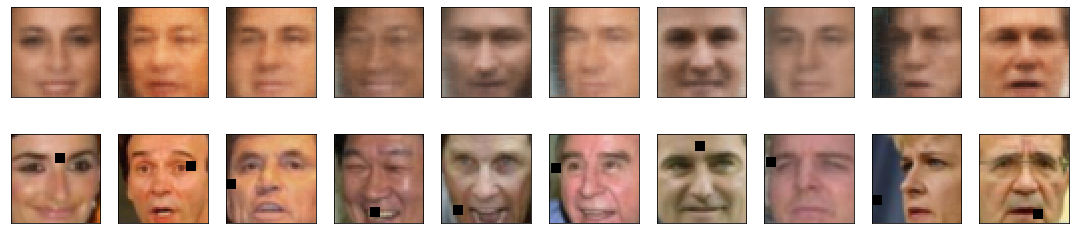

In [ ]:
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
b = images[1].to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(np.concatenate((a,b), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)

как видно из фотографий модель работает верно

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
LATTENT_VECTORS=[]
IMG_VECTORS=[]


In [ ]:
for images in data_val:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, latent_code = autoencoder(images)
        LATTENT_VECTORS.append(latent_code.to("cpu").clone().detach().numpy())
        IMG_VECTORS.append(images)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
latt=[]
IMG_VEC=[]

for val in LATTENT_VECTORS:
  for i in range(val.shape[0]):
    latt.append(val[i])

for val in IMG_VECTORS:
  for i in range(val.shape[0]):
    IMG_VEC.append(val[i])




In [ ]:
codes = latt

In [ ]:
IMG_VEC[0].shape

torch.Size([3, 45, 45])

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors(n_neighbors=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей
  image = image.to(device) 
  reconstruction, latent_code = autoencoder(image)
  code = latent_code[0].to("cpu").clone().detach().numpy()
  vectors = torch.Tensor(n_neighbors, 3, 45, 45)
  A = lshf.kneighbors_graph([code], n_neighbors=n_neighbors)
  A = A.toarray()
  j = 0 
  for i,vec in enumerate(A[0]):
    if vec == 1:
      vectors[j] = IMG_VEC[i]
      j+=1

  return vectors

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image[0].cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().detach().numpy().transpose([1,2,0]))
        #plt.title("Dist=%.3f"%distances[i])
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


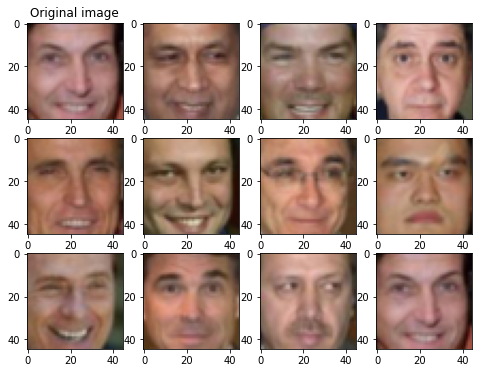

In [ ]:
show_similar(images)

Из результата видно, что модель находит похожих друг на друга людей.

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!